In [8]:
# pkg import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark

%matplotlib inline

## 1. Data Importing

In [68]:
# define the schema
from pyspark.sql.types import IntegerType, StringType, StructField, StructType, TimestampType, BooleanType, DoubleType
schema = StructType([
    StructField('order_id',IntegerType(),True),
    StructField('shop_id',IntegerType(),True),
    StructField('user_id',IntegerType(),True),
    StructField('order_amount',DoubleType(),True),
    StructField('total_items',IntegerType(),True),
    StructField('payment_method',StringType(),True),
    StructField('created_at',TimestampType(),True)
])

In [74]:
# read the data
from pyspark.sql.functions import to_date, col,to_timestamp, split

data = spark.read.csv('data.csv',header=True,schema=schema).\
withColumn('date', to_date(col('created_at'),'yyyy-MM-dd HH:mm:ss a')).\
orderBy('date')

In [75]:
data.show()

+--------+-------+-------+------------+-----------+--------------+-------------------+----------+
|order_id|shop_id|user_id|order_amount|total_items|payment_method|         created_at|      date|
+--------+-------+-------+------------+-----------+--------------+-------------------+----------+
|     669|     16|    975|       156.0|          1|         debit|2017-03-01 17:00:07|2017-03-01|
|    1268|     80|    798|       290.0|          2|   credit_card|2017-03-01 00:19:31|2017-03-01|
|     683|      6|    847|       187.0|          1|          cash|2017-03-01 09:06:32|2017-03-01|
|       7|     87|    915|       149.0|          1|          cash|2017-03-01 21:37:57|2017-03-01|
|     699|     40|    734|       483.0|          3|          cash|2017-03-01 07:05:33|2017-03-01|
|      67|     66|    743|       322.0|          2|          cash|2017-03-01 10:40:40|2017-03-01|
|     719|     60|    727|       177.0|          1|   credit_card|2017-03-01 11:08:20|2017-03-01|
|      96|     35|  

## 2. Outlier Detection for Shoe Price

In [79]:
#add price_per_item column
data = data.withColumn('price_per_item',data['order_amount']/data['total_items'])

In [81]:
data.show(6)

+--------+-------+-------+------------+-----------+--------------+-------------------+----------+--------------+
|order_id|shop_id|user_id|order_amount|total_items|payment_method|         created_at|      date|price_per_item|
+--------+-------+-------+------------+-----------+--------------+-------------------+----------+--------------+
|      96|     35|    975|       328.0|          2|   credit_card|2017-03-01 06:27:42|2017-03-01|         164.0|
|     352|     34|    956|       244.0|          2|         debit|2017-03-01 10:21:45|2017-03-01|         122.0|
|     109|     58|    926|       276.0|          2|          cash|2017-03-01 03:15:13|2017-03-01|         138.0|
|       7|     87|    915|       149.0|          1|          cash|2017-03-01 21:37:57|2017-03-01|         149.0|
|     110|     58|    774|       414.0|          3|          cash|2017-03-01 10:01:23|2017-03-01|         138.0|
|      67|     66|    743|       322.0|          2|          cash|2017-03-01 10:40:40|2017-03-01

In [95]:
#Check outliers for price_per_item
data.select('shop_id','price_per_item').distinct().orderBy('shop_id').show(100)

+-------+--------------+
|shop_id|price_per_item|
+-------+--------------+
|      1|         158.0|
|      2|          94.0|
|      3|         148.0|
|      4|         128.0|
|      5|         142.0|
|      6|         187.0|
|      7|         112.0|
|      8|         132.0|
|      9|         118.0|
|     10|         148.0|
|     11|         184.0|
|     12|         201.0|
|     13|         160.0|
|     14|         116.0|
|     15|         153.0|
|     16|         156.0|
|     17|         176.0|
|     18|         156.0|
|     19|         163.0|
|     20|         127.0|
|     21|         142.0|
|     22|         146.0|
|     23|         156.0|
|     24|         140.0|
|     25|         130.0|
|     26|         176.0|
|     27|         169.0|
|     28|         164.0|
|     29|         163.0|
|     30|         153.0|
|     31|         129.0|
|     32|         101.0|
|     33|         173.0|
|     34|         122.0|
|     35|         164.0|
|     36|         130.0|
|     37|         142.0|


In [189]:
# from above we can see the shop78's shoes is super expensive

In [103]:
data.filter(col('shop_id')==78).show(100)

+--------+-------+-------+------------+-----------+--------------+-------------------+----------+--------------+
|order_id|shop_id|user_id|order_amount|total_items|payment_method|         created_at|      date|price_per_item|
+--------+-------+-------+------------+-----------+--------------+-------------------+----------+--------------+
|    4312|     78|    960|     51450.0|          2|         debit|2017-03-01 03:02:10|2017-03-01|       25725.0|
|    4041|     78|    852|     25725.0|          1|          cash|2017-03-02 14:31:12|2017-03-02|       25725.0|
|    2822|     78|    814|     51450.0|          2|          cash|2017-03-02 17:13:25|2017-03-02|       25725.0|
|    4413|     78|    756|     51450.0|          2|         debit|2017-03-02 04:13:39|2017-03-02|       25725.0|
|    2493|     78|    834|    102900.0|          4|         debit|2017-03-04 04:37:34|2017-03-04|       25725.0|
|    4716|     78|    818|     77175.0|          3|         debit|2017-03-05 05:10:44|2017-03-05

## 3. Further Exploration on Sales Amount

In [115]:
# transform to pandas dataframe
df = data.toPandas()

In [117]:
df.head(2)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,date,price_per_item
0,5,18,883,156.0,1,credit_card,2017-03-01 04:35:11,2017-03-01,156.0
1,7,87,915,149.0,1,cash,2017-03-01 21:37:57,2017-03-01,149.0


In [138]:
# Total amount sales in the month
total_sales = sum(df['order_amount'])

#sales for shop 78
sales_78_df = df[df['shop_id']==78]
sales_78 = sum(sales_78_df['order_amount'])

In [139]:
# percentage of sales for shop78 in total_sales
sales_78/total_sales

0.1439559852571978

In [140]:
# sales amount by shop_id
total_sales_by_shop = []
for i in range(1,101):
    sales_i = df[df['shop_id']==i]
    total_sales_by_shop.append(sum(sales_i['order_amount']))

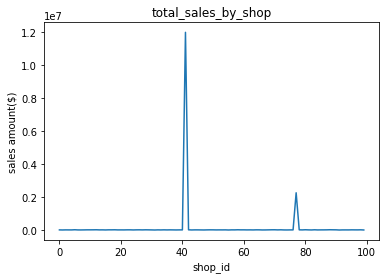

In [181]:
plt.plot(total_sales_by_shop)
plt.title('total_sales_by_shop')
plt.xlabel('shop_id')
plt.ylabel('sales amount($)')
plt.show()

In [146]:
#outlier detection for shop42
sales_42_df = df[df['shop_id']==42]
sales_42 = sum(sales_41_df['order_amount'])

sales_42/total_sales

0.7624602877847897

In [190]:
# check shop42 records
sales_42_df

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,date,price_per_item
68,2019,42,739,352.0,1,debit,2017-03-01 12:42:26,2017-03-01,352.0
85,2492,42,868,704.0,2,debit,2017-03-01 18:33:33,2017-03-01,352.0
157,4422,42,736,704.0,2,credit_card,2017-03-01 12:19:49,2017-03-01,352.0
197,521,42,607,704000.0,2000,credit_card,2017-03-02 04:00:00,2017-03-02,352.0
345,4647,42,607,704000.0,2000,credit_card,2017-03-02 04:00:00,2017-03-02,352.0
456,2988,42,819,1056.0,3,cash,2017-03-03 09:09:25,2017-03-03,352.0
529,61,42,607,704000.0,2000,credit_card,2017-03-04 04:00:00,2017-03-04,352.0
549,410,42,904,704.0,2,credit_card,2017-03-04 14:32:58,2017-03-04,352.0
666,4232,42,962,352.0,1,cash,2017-03-04 00:01:19,2017-03-04,352.0
783,2767,42,970,704.0,2,credit_card,2017-03-05 10:45:42,2017-03-05,352.0


In [182]:
# suspected for user 607: 704000/ 2000
sales_42_df[sales_42_df['user_id']==607]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,date,price_per_item
197,521,42,607,704000.0,2000,credit_card,2017-03-02 04:00:00,2017-03-02,352.0
345,4647,42,607,704000.0,2000,credit_card,2017-03-02 04:00:00,2017-03-02,352.0
529,61,42,607,704000.0,2000,credit_card,2017-03-04 04:00:00,2017-03-04,352.0
1002,16,42,607,704000.0,2000,credit_card,2017-03-07 04:00:00,2017-03-07,352.0
1095,2298,42,607,704000.0,2000,credit_card,2017-03-07 04:00:00,2017-03-07,352.0
1771,1437,42,607,704000.0,2000,credit_card,2017-03-11 04:00:00,2017-03-11,352.0
1954,2154,42,607,704000.0,2000,credit_card,2017-03-12 04:00:00,2017-03-12,352.0
2389,1363,42,607,704000.0,2000,credit_card,2017-03-15 04:00:00,2017-03-15,352.0
2706,1603,42,607,704000.0,2000,credit_card,2017-03-17 04:00:00,2017-03-17,352.0
3052,1563,42,607,704000.0,2000,credit_card,2017-03-19 04:00:00,2017-03-19,352.0


In [151]:
# new metric: Average order value by Shop (AOVS)
AOVS = []
for i in range(1,101):
    shop_df = df[df['shop_id']==i]
    order_num = len(shop_df)
    AOVS.append(sum(shop_df['order_amount'])/order_num)
AOVS_df = pd.DataFrame()
AOVS_df['shop_id'] = [i for i in range(1,101)]
AOVS_df['AOVS'] = AOVS

In [152]:
AOVS_df

,shop_id,AOVS
0,1,308.818182
1,2,174.327273
2,3,305.250000
3,4,258.509804
4,5,290.311111
...,...,...
95,96,330.000000
96,97,324.000000
97,98,245.362069
98,99,339.444444


In [188]:
# save as excel file
AOVS_df.to_excel('AOVS_df.xlsx')

In [173]:
# filter outliers shop78 and shop42
filter_AOVS_df = AOVS_df[AOVS_df['shop_id'] != 78]
filter_AOVS_df = filter_AOVS_df[filter_AOVS_df['shop_id'] != 42]

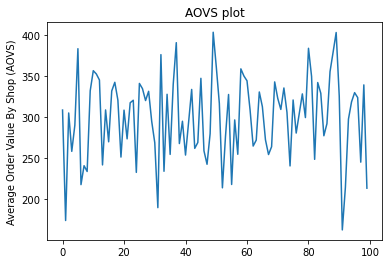

In [184]:
plt.plot(filter_AOVS_df['AOVS'])
plt.title('AOVS plot')
plt.ylabel('Average Order Value By Shop (AOVS)')
plt.show()

In [186]:
# Average AOVS for shops (delete outliers)
np.mean(filter_AOVS_df['AOVS'])

299.68239912615485